# Complete Galaxy Catalog

## Load data and pixelate catalogue (or load one already pixelated)

In [1]:
import os,sys
os.environ["CHIMERA_ENABLE_GPU"] = "False"
sys.path.append(os.getcwd()+'/../')
from CHIMERA import data as data
import h5py


fpe = "./data/PE_O5Like_snr20.h5"
gw_pe_det = data.load_gw_pe_samples(fpe, parameters=['m1det', 'm2det', 'dL', 'ra', 'dec', 'phi', 'theta'])
gw_pe_det = gw_pe_det.update(pe_prior=gw_pe_det.dL**2)

# To pixelize the catalog if not done yet
"""
nside_list = [512, 256, 128, 64, 32, 16, 8]
mean_npixels_event = 15
prefix = "./data/PE_O5Like_snr20"
nest = False
sky_conf = 0.9
gw_pe_det_pixelated = data.pixelize_gw_catalog(gw_pe_det,
                       nside_list,
                       mean_npixels_event,
                       sky_conf,
                       nest,
                       prefix,
                       ret_datastruct=True)
"""

f_gw_pix = './data/PE_O5Like_snr20_pixelated_nsidelist512-256-128-64-32-16-8_meanpixels15_skyconf0.9_nestFalse.h5'
gw_pe_det_pixelated = data.load_pixelated_gw_catalog(f_gw_pix)

2025-07-31 17:26:32,795 - CHIMERA - INFO - Loading `CHIMERA`. GPU acceleration: False


## Instantiate population objects

In [2]:
from CHIMERA.cosmo import flrw
from CHIMERA.mass import plp
from CHIMERA.rate import madau_dickinson
from CHIMERA.catalog import dVdz_completeness, pixelated_catalog
from CHIMERA import population, compute_z_grids

fname_gal    = "./data/MICEv2_1.6M_L-compl_UCV.h5"
fname_interp = "./data/p_bkg_gauss_smooth_zerr0.001_zres5000_smooth30.pkl"

cosmo = flrw(H0 = 70., 
             Om0=0.25,
            z_max = 5.)

z_grids = compute_z_grids(cosmo, 
                          gw_pe_det_pixelated, 
                          cosmo_prior = {'H0':[20,200]}, 
                          z_int_res = 500,)

completeness = dVdz_completeness(z_range= [0.073, 1.3]) # mask_file for 
gal_cat = pixelated_catalog(completeness, 
                            gal_cat_file='galcat_test.h5',
                            # if the argument above is None it is necessary to specify the argument below to compute p_cat
                            cosmo = cosmo,
                            z_grids = z_grids, 
                            fname_data_gal = fname_gal, 
                            data_gw_pixelated = gw_pe_det_pixelated, 
                            fname_interp = fname_interp, 
                            z_err = 0.001,
                            out_file = 'galcat_test.h5'
                           )

mass = plp()
rate = madau_dickinson(gamma = 2.7,
                       kappa =  3.,
                       zp = 2.)

population = population(cosmo, mass, rate, gal_cat=gal_cat, scale_free=True)

2025-07-31 17:26:34,924 - CHIMERA - INFO - Loading gal_cat object from galcat_test.h5


## Plot pixelization scheme

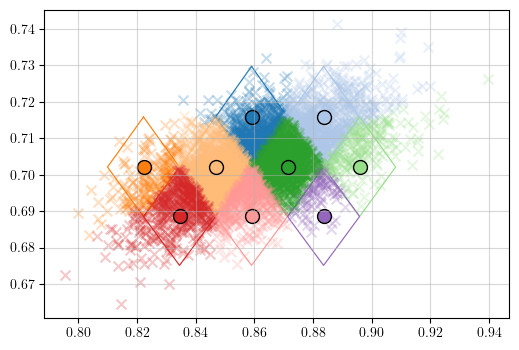

In [3]:
from CHIMERA.utils.plotting import plot_pixelization
import matplotlib.pyplot as plt

plot_pixelization(gw_pe_det_pixelated, 5)

## Instantiate bias object

In [4]:
from CHIMERA import selection_function
from CHIMERA.utils.config import jax, jnp
from tqdm import tqdm 

file_inj = "./data/injections_20M_sources_PLP_v9s2_H1-L1-Virgo-KAGRA-LIGOI_IMRPhenomHM_snr_th-20_dutyfac-1_fmin-10_noiseless.h5"
gw_inj_data = data.load_injection_data(file_inj, snr_cut=20, return_struct = True)
# inj_prior *= 1000 needed for LVK injection drawn from \pi_{draw} in which ddL/dz is in Mpc instead of Gpc

sel_fcn = selection_function(gw_inj_data, N_inj=20*1e6)

## Instantiate the hyperlikelihood 

In [5]:
from CHIMERA import hyperlikelihood


like_jax = hyperlikelihood(  
    # data
    gw_pe_det_pixelated,
    # z_grids
    z_grids,
    # pop model
    population=population,
    # bias model
    selection_function=sel_fcn,
    # KDE settings
    kind_p_gw3d = 'marginalized', # 'full', 'approximated'
    kernel='epan', # 'epan'
    bw_method=None,
    cut_grid=2,
    binning=True,
    num_bins=200,
)

2025-07-31 17:26:36,758 - CHIMERA - INFO - Created hyperlikelihood model. Using 300 GW events.


## 1d over H0

100it [02:29,  1.50s/it]
/tmp/ipykernel_83031/3262668278.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_jax /= np.trapz(post_jax, H0)


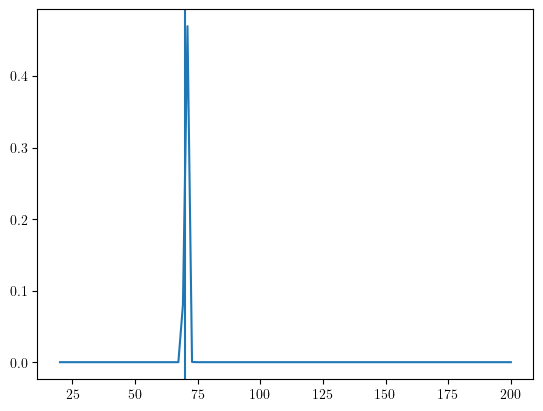

In [6]:
import numpy as np
import jax.numpy as jnp
import tqdm
import matplotlib.pyplot as plt

H0 = jnp.linspace(20, 200, 100)
# res_H0 = np.zeros((H0.shape[0], like_jax.z_int_res))
res_H0 = np.zeros_like(H0)

for i, h0 in tqdm.tqdm(enumerate(H0)):
  res = like_jax(H0 = h0)
  res_H0[i] = res
  
# exponentiate and normalize

post_jax = res_H0.copy()
post_jax -= np.nanmax(post_jax)
post_jax = np.exp(post_jax)
post_jax /= np.trapz(post_jax, H0)

plt.plot(H0, post_jax)
plt.axvline(70)